# Imports and package set-up

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import tensorflow as tf

from hyperopt import fmin, tpe, hp, Trials
from tensorflow.keras import activations, layers, optimizers, regularizers
from tensorflow.keras.layers import Dense

COLAB = 'google.colab' in str(get_ipython())
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive/',)
    %cd /content/drive/MyDrive/Thesis/

Mounted at /content/drive/
/content/drive/MyDrive/Thesis


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # should shut TF up a bit
sns.set()
np.set_printoptions(threshold=256)
rc = {
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "figure.dpi": 100,
    "figure.figsize": [9, 5],
    "font.serif": ["Charter"] + plt.rcParams["font.serif"],
    # 'text.usetex': True,
    # 'text.latex.preamble': [r'\usepackage{amsmath}']
}
plt.rcParams.update(rc)

In [3]:
LOSS_FOLDER = './new_test_losses/'
HYPEROPT_FOLDER = './hyperopt/'

# Simulate

In [4]:
class SimulateData(object):
    def __init__(self, situation, n, one_hot=True, seed=None, equi_distant=False):
        self.situation = situation
        self.n = n
        if seed is not None: np.random.seed(seed)  # note: assuming samplig with np
        
        self.X, self.funcs = self.situational_stuff(equi_distant)
        self.d = 1 if self.X[0].ndim == 0 else self.X[0].shape
        self.K = len(self.funcs)
        
        self.f_X = np.array([f(self.X) for f in self.funcs]).T
        self.Y_prob = np.array([self.f_X[i] / x_sum for i, x_sum in enumerate(self.f_X.sum(axis=1))])
        
        if one_hot: self.Y_one_hot = self.one_hot_from_Y_probs()
        
    def unif_rejection_sampling(self, p):
        # Rejection sampling from density function p; proposal is unif[0, 1].
        # MAYDO: faster sampling method.
        q_pdf = ss.uniform().pdf
        q_sample = np.random.uniform
    
        grid = np.linspace(0, 1, 1000)
        m = max(p(grid)) * 1.3  # should divide by q_pdf(grid) but that's always 1.
        # The 1.3 factor is just to be sure m * q > p. Proportion accepted ~ 1/m.
    
        X = []
        while len(X) < self.n:
            z = q_sample()
            if np.random.uniform(0, m * q_pdf(z)) <= p(z):
                X.append(z)
        return np.array(X)
    
    def situational_stuff(self, equi_distant):
        # Default:
        X = np.random.uniform(size=self.n) if not equi_distant else np.linspace(0, 1, self.n)
        # TODO?: rm the equidistant thing? It makes _some_ sense.
        
        if self.situation == "Simple 1D":
            def f1(X): return (1 + X) / 3
            def f2(X): return (2 - X) / 3
            return X, [f1, f2] 
        
        if self.situation == "Simple 2D":
            # desc = f"Situation 2: sampling {n} X_i ~ 2D uniforms. f1(X) = sum(X) / 2. K = 2."
            X1 = np.random.uniform(size=self.n)
            X2 = np.random.uniform(size=self.n)
            X = np.column_stack([X1, X2])
            def f1(X): return (X[:, 0] + X[:, 1]) / 2
            def f2(X): return 1 - f1(X)
            return X, [f1, f2]
        
        if "x^" in self.situation:
            # TODO again probably, this string stuff
            r_str = self.situation.split('^')[1].split(' ')[0]
            r = int(r_str) if r_str.isdigit() else 5
            
            # Allow doing something linear after specified b, default to 1
            b_str = self.situation.split('b=')[1].split(' ')[0] if "b=" in self.situation else "not a valid float"
            b = float(b_str) if b_str[0] in ["0", "."] else 1
            br = b ** r
            def f1(X): return np.array([br + X_i - b if X_i > b else X_i ** r for X_i in X])
            def f2(X): return br + 1 - b - f1(X)
            return X, [f1, f2]
        
        if self.situation == "Mixture of uniforms":
            # TODO: parametrize in that string.
            a = [0.05, .55]
            b = [.45, .95]
            pY = [.5,.5]
    
            def p(x):
                return sum([ss.uniform(a[i], b[i]).pdf(x) * pY[i] for i in range(len(pY))])
    
            X = self.unif_rejection_sampling(p)
            def f1(X): return 1 / (1 + np.power(X / (1 - X), - 1 * 3))
            def f2(X): return 1 - f1(X)
            return X, [f1, f2]   
        
        if "sin(" in self.situation:
            more = self.situation.split('+1')
            minimum = float(more[1]) if len(more[1]) > 1 else 0
            def f1(X): return np.sin(2 * np.math.pi * X) + 1 + minimum
            # Or Taylor approximation
            # if "Taylor" in self.situation:
            #     def f1(X, m = 10):
            #         Xp = 2 * np.math.pi * X
            #         return 1 + sum([(-1) ** (i+1) * Xp ** (2*i-1) / np.math.factorial(2*i-1) 
            #                         for i in range(1, m)])
            def f2(X): return 2 + 2 * minimum - f1(X)
            return X, [f1, f2]

        if "sigmoid" in self.situation:
            beta = 4
            def f1(X): return 1 / (1 + np.power(X / (1 - X), - 1 * beta))
            def f2(X): return 1 - f1(X)
            return X, [f1, f2]
        
        else:
            raise ValueError("Situation not implemented.")
    
    def one_hot_from_Y_probs(self):
        # Assign sample to category with a categorical probability.
        Y_cat = np.array([np.random.choice(self.K, 1, p=p) for p in self.Y_prob])
        return np.eye(self.K)[Y_cat.reshape(-1,)]
        
    def visualize(self):
        # TODO: a savefig option
        print("Euclidean distance between non- and normalized:", np.linalg.norm(self.f_X - self.Y_prob))

        t_space = np.geomspace(1e-20, 1, 10_000)  # denser where small.
        p_X_smaller = [np.mean(self.Y_prob <= t) for t in t_space]

        if self.X.ndim > 2:
            print("$\mathbf{X}$ dimensionality too high to visualize.")
            return -1
        
        plt.figure(); plt.xlabel("$x$"); plt.ylim(0, 1.05)
        if self.X.ndim == 1:
            plt.plot(t_space, p_X_smaller, color='red', label='$\mathrm{\mathbb{P}}(\mathbf{p}(X) \leq x)$')
            plt.plot(t_space, t_space, '--', alpha=.3, color='red')
            x, _, p = plt.hist(self.X, bins=30, density=True, alpha=.3, label='Scaled density of $X$ realizations')
            # Histogram scaling:
            for item in p: item.set_height(item.get_height() / max(x))
            
            # Empirical function plotting:
            order = np.argsort(self.X)
            for i in range(self.Y_prob.shape[1]):
                plt.plot(self.X[order], self.Y_prob[order, i], label=f'Normalized $p^0_{i+1}(x)$')
    
            plt.legend(); plt.show()
        elif self.X.ndim == 2:
            plt.plot(t_space, p_X_smaller, color='red', label='$\mathrm{\mathbb{P}}(\mathbf{p}(\mathbf{X}) \leq x)$')
            x, _, p = plt.hist(self.X, bins=30, density=True, alpha=.3,
                               label=[f'Scaled density of $X_{j+1}$ realizations' for j in range(self.X.shape[1])])
            for j in range(self.X.ndim):
                for item in p[j]:
                    item.set_height(item.get_height() / max(x[j]))
            
            plt.legend(); plt.show()

            # New 3D plot:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")
    
            subset = np.random.choice(self.X.shape[0], 200)
            for i in range(self.Y_prob.shape[1]):
                ax.scatter(self.X[subset, 0], self.X[subset, 1], self.Y_prob[subset, i],
                           label=f'$p^0_{i+1}(\mathbf{{x}})$')
            ax.set_xlabel('$x_1$')
            ax.set_ylabel('$x_2$')
            ax.legend()
            plt.show()

# Network stuff

In [5]:
class KerasModelStuff(object):
    def __init__(self, train, val, hidden_widths=[16, 16, 16, 16], l1=.0005):
        self.train = train
        self.val = val

        if self.train.X.ndim == 1:
            # Maybe TODO: copy the data if modifying it.
            self.train.X = self.train.X.reshape(-1, 1)
            self.val.X = self.val.X.reshape(-1, 1)

        self.model = self.initialize_model(hidden_widths, l1)
        self.history = None

    def initialize_model(self, hidden_widths, l1):
        # ReLU activations for hidden layers, softmax without weights before output.
        # Force _some_ sparsity. Note: not the same as theory (yet).

        m = [self.train.X[0].shape, *hidden_widths, self.train.K]
        model = tf.keras.models.Sequential(name=f'L-is-{len(hidden_widths)}-and-p_0-is-{m[0][0]}...')

        model.add(Dense(m[1], input_shape=m[0], name=f'p_0->p_1',
                        kernel_regularizer=regularizers.l1(l1),
                        bias_regularizer=regularizers.l1(l1)))
        for i in range(2, len(m)):
            model.add(Dense(m[i], activation='relu', name=f'p_{i-1}->p_{i}',
                      kernel_regularizer=regularizers.l1(l1),
                      bias_regularizer=regularizers.l1(l1)))
        model.add(layers.Activation(activations.softmax))
        return model
    
    def train_network(self, opt='adam', stop=.002, viz=0, seed=None):
        if seed is not None:
            tf.random.set_seed(seed)

        # TODO: note the much higher stop
        if viz > 1: print(self.model.summary())
        self.model.compile(opt, 'categorical_crossentropy')
        
        # TODO: still playing with magic numbers below
        cb = [tf.keras.callbacks.EarlyStopping('loss', min_delta=stop, patience=10, 
                                               verbose=viz, restore_best_weights=True)]
        bs = np.max([round(self.train.n / 512), 4])
        self.history = self.model.fit(self.train.X, self.train.Y_one_hot, epochs=100, callbacks=cb,
                                      validation_data=(self.val.X, self.val.Y_one_hot),
                                      batch_size=bs, use_multiprocessing=True, 
                                      verbose=0 if viz < 2 else 2, shuffle=False)

        if viz > 0:
            pd.DataFrame(self.history.history).plot()
            plt.gca().set_ylim(0, max(1, np.quantile(self.history.history['val_loss'], .98)))
            plt.grid(True); plt.xlabel('Epoch'); plt.show()

    def KL_trunc_loss(self, true, pred, B, minimum=1e-4):
        # Ugly and slow to make it transparent, bc I'm not sure.
        divergences = []
        for i, true_vec_i in enumerate(true):
            pred_vec_i = pred[i]
            current_sum = 0
            for k, true_i_k in enumerate(true_vec_i):
                pred_i_k = pred_vec_i[k]
                if pred_i_k < minimum:
                    current_sum += true_i_k * B
                else:
                    current_sum += true_i_k * np.minimum(B, np.log(true_i_k / pred_i_k))
            divergences.append(current_sum)
        return np.mean(divergences)

    def get_sparsity(self, epsilon=.001):
        W = self.model.get_weights()
        nz_biases = biases = nz_weights = weights = over_one = 0
        for i, W_i in enumerate(W):
            over_one += np.count_nonzero(W_i > 1)
            if i % 2 == 0:
                nz_weights += np.count_nonzero(W_i > epsilon)
                weights += W_i.size
            else:
                nz_biases += np.count_nonzero(W_i > epsilon)
                biases += W_i.size
        return {
            f"Biases > {epsilon}": nz_biases, "Biases total": biases,
            f"Weights > {epsilon}": nz_weights, "Weights total": weights,
            "s": nz_biases + nz_weights, "Weights and biases > 1": over_one
        }
    
    def KL_prob_val_loss(self):
        return tf.keras.losses.KLDivergence()(self.val.Y_prob, self.model.predict(self.val.X)).numpy().mean()

    def evaluate(self, test, B=1.5, visualize=True, loss_only=False):
        p = self.model.predict(test.X)
        t = test.Y_prob
        
        if visualize:
            if self.train.d == 1:
                plt.figure(); plt.xlabel("$x$"); plt.ylim(0, 1.05)
                x, _, items = plt.hist(self.train.X, bins=30, density=True, alpha=.3, 
                                    label='Scaled density of $X$ (train) realizations')
                # Histogram scaling:
                for item in items:
                    item.set_height(item.get_height() / max(x))
                testX = test.X[:, 0] if test.X.ndim == 2 else test.X  # undo annoying reshape trick
                order = np.argsort(testX)
                for k in range(self.train.K):
                    plt.plot(testX[order], test.Y_prob[order, k], label=f'$p^0_{k+1}(x)$')
                    plt.plot(testX[order], p[order, k], '--', label=f'$\hat{{p}}_{k+1}(x)$',
                             color=plt.gca().lines[-1].get_color())
                plt.legend()
                plt.show()
            # TODO: insert 2D here (I have it somewhere below)
            else:
                print("$\mathbf{X}$ dimensionality too high to visualize.")

        
        losses = {
            "LL": tf.keras.losses.categorical_crossentropy(t, p).numpy().mean(),
            "MSE": tf.keras.losses.MeanSquaredError()(t, p).numpy(),
            "KL": tf.keras.losses.KLDivergence()(t, p).numpy().mean(),
            f"KL_B={B}": self.KL_trunc_loss(t, p, B)
        }
        if loss_only:
            return losses
        else:
            return {**losses, **self.get_sparsity(), "Pr. max difference": np.amax(np.abs(t - p))}

# Actual experiments

In [6]:
def opt_network(situation, n, evals=50, opt_repeats=2, viz=0):
    param_space = {
        'L': 2 + hp.randint('L-2', int(np.log(n) * 1.2)),
        'w': 8 + hp.randint('w-8', np.min([88, np.max([8, int(.05 * n)])])), # 16-96
        'lr': hp.uniform('lr', 0.0001, 0.0008),
        'l1': hp.uniform('l1', 0.0001, 0.001),
    }
    print(f"Searching for optimal {param_space.keys()} in {evals} attempts.")
    print(f"We're in situation {situation} with {n} samples.")

    def obj(params):
        hw = [params['w'] for _ in range(params['L'])]
        opt = optimizers.Adam(params['lr'])
        
        # Try a few trainings, return the best:
        train = SimulateData(situation, n)  # there's no default seed
        val = SimulateData(situation, 10**4)
        KLs = []
        for _ in range(opt_repeats):
            kn = KerasModelStuff(train, val, hidden_widths=hw, l1=params['l1'])
            kn.train_network(opt=opt)
            KLs.append(kn.KL_prob_val_loss())
        if viz > 0:
            print(f"{KLs} with {params}")
        return np.min(KLs)

    filename = f"{HYPEROPT_FOLDER}{situation}__{n}.hyperopt"
    try: 
        trials = pickle.load(open(filename, "rb"))
        if evals <= len(trials.trials):
            trials.vals
            losses = np.asarray(trials.losses(), dtype=float)
            best_i = np.argmin(losses)
            best_params = {key: values[best_i] for key, values in trials.vals.items()}
            print("Already did", len(trials.trials), ">=", evals, "trials")
            return best_params, trials
        print(f"Found {len(trials.trials)} trials, so doing {evals - len(trials.trials)}.")
    except:
        if evals == 0:
            raise ValueError(f'evals == 0 and no {filename} found.')
        print(f"{filename} not found, starting trials from scratch.")
        trials = Trials()

    tpe_best = fmin(fn=obj, space=param_space, algo=tpe.suggest, max_evals=evals, trials=trials)
    with open(filename, "wb") as f:
        pickle.dump(trials, f)

    return tpe_best, trials

def evaluate_params(situation, n, test, n_repeats, n_retrains=5, opt_evals=1, params=None, viz=0):
    filename = f"{LOSS_FOLDER}{situation}__{n}.pkl"
    try: 
        losses = pickle.load(open(filename, "rb"))
    except:
        losses = {'KL': [], 'MSE': []}
    n_found = len(losses['KL'])

    # if n_repeats <= n_found: 
    #     print("Already done, return found", filename)
    #     return losses
    assert test.situation == situation

    if params is None:
        params, _ = opt_network(situation, n, opt_evals, n_retrains)
    else:
        params['w-8'] += round(np.log2(n / 512))

    print(f"\n{situation, n} -- evaluating on test", 
          np.max([0, n_repeats - n_found]), "time(s) with parameters", params)
    hw = [params['w-8'] + 8 for _ in range(params['L-2'] + 2)]
    opt = optimizers.Adam(params['lr'])
    for i in range(n_found, np.max([n_found, n_repeats])):
        train = SimulateData(situation, n, seed=i)  # havent'checked if this seed makes all the rest deterministic
        val = SimulateData(situation, 10**4, equi_distant=True)    
        KLs = []
        networks = []
        for j in range(n_retrains):
            km = KerasModelStuff(train, val, hidden_widths=hw, l1=params['l1'])
            km.train_network(opt=opt, seed=j)
            networks.append(km)
            KLs.append(km.KL_prob_val_loss())
            print(KLs)

        best_km = networks[np.argmin(KLs)]
        results = best_km.evaluate(test)
        print(results)
        losses['KL'].append(results['KL'])
        losses['MSE'].append(results['MSE'])
        
        # Backup every time
        with open(filename, "wb") as f:
            pickle.dump(losses, f)
    
    return losses

In [7]:
n_repeats = 15
n_retrains = 5  # keep >= 4 to keep some quality in the saved files
opt_evals = 20
viz = 1
params = {'L-2': 2, 'l1': 0.00025, 'lr': 0.0006, 'w-8': 16}
# params = None  # for opt-ing.
# w depends on n a bit even if a full params dict is specified.


('sin(2*pi*x)+1', 512) -- evaluating on test 0 time(s) with parameters {'L-2': 2, 'l1': 0.00025, 'lr': 0.0006, 'w-8': 16}
{'KL': [0.02013981, 0.035037138, 0.03342036, 0.052810732, 0.041658755, 0.036896054, 0.037370414, 0.052294843, 0.01904672, 0.046620954, 0.026757803, 0.014176732, 0.024883853, 0.04173648, 0.023108838], 'MSE': [0.003946261, 0.009303024, 0.009261864, 0.016443603, 0.010473838, 0.009199428, 0.009283576, 0.012552327, 0.0034833106, 0.010681946, 0.006235703, 0.0033192486, 0.005610257, 0.010222301, 0.0045307158]}

('sin(2*pi*x)+1', 768) -- evaluating on test 0 time(s) with parameters {'L-2': 2, 'l1': 0.00025, 'lr': 0.0006, 'w-8': 17}
{'KL': [0.015658906, 0.040743783, 0.038698334, 0.0546837, 0.03119772, 0.021127382, 0.01791235, 0.04638541, 0.03649189, 0.02785647, 0.023660056, 0.024057455, 0.01736807, 0.0118928, 0.026672974], 'MSE': [0.0037920042, 0.009196741, 0.00857293, 0.014364114, 0.0082407985, 0.005692973, 0.0038334287, 0.012379705, 0.010803935, 0.007082192, 0.0055291555,

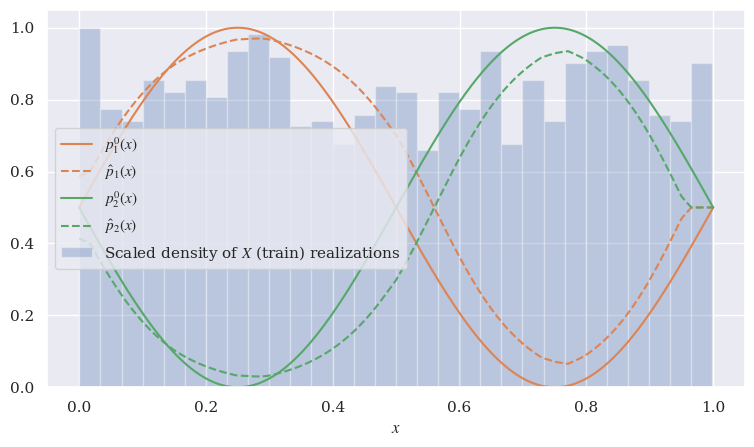

{'LL': 0.42073625, 'MSE': 0.010258181, 'KL': 0.034523662, 'KL_B=1.5': 0.03452366467783698, 'Biases > 0.001': 41, 'Biases total': 114, 'Weights > 0.001': 297, 'Weights total': 2436, 's': 338, 'Weights and biases > 1': 0, 'Pr. max difference': 0.20180911220333808}
[0.032879665]
[0.032879665, 0.03420337]
[0.032879665, 0.03420337, 0.30682215]


In [ ]:
situation_list = ['sin(2*pi*x)+1', 'sin(2*pi*x)+1.2']
# n_list = [256, 512, 768, 1024, 1536, 2048, 3072, 4096, 8192]
n_list = [512, 768, 1024, 1536, 2048]
KL_means = np.zeros((len(situation_list), len(n_list)))
MSE_means = np.zeros((len(situation_list), len(n_list)))
KL_medians = np.zeros((len(situation_list), len(n_list)))
MSE_medians = np.zeros((len(situation_list), len(n_list)))
for i, situation in enumerate(situation_list):
    test = SimulateData(situation, 10**5)
    for j, n in enumerate(n_list):
        # losses = pickle.load(open(f'./test_losses/{situation}__{n}.pkl', "rb"))
        losses = evaluate_params(situation, n, test, n_repeats, n_retrains, opt_evals, params)
        print(losses)
        KL_means[i, j] = np.mean(losses['KL'])
        MSE_means[i, j] = np.mean(losses['MSE'])
        KL_medians[i, j] = np.median(losses['KL'])
        MSE_medians[i, j] = np.median(losses['MSE'])

In [ ]:
plt.figure(); plt.xlabel("$n$")
plt.title(f'KL full, MSE dotted')
for i, situation in enumerate(situation_list): 
    plt.plot(n_list, KL_medians[i], label=f"{situation}")
    plt.plot(n_list, MSE_medians[i], '--', color=plt.gca().lines[-1].get_color())
plt.legend()
plt.plot

KL_med_df = pd.DataFrame(np.transpose(KL_medians.round(5)))
KL_med_df.columns = [f'{s}' for s in situation_list]
KL_med_df.index = [f'{n}' for n in n_list]

print(KL_med_df)

# plt.figure(); plt.xlabel("$n$")
# plt.title(f'MSE')
# for i, situation in enumerate(situation_list): 
#     plt.plot(n_list, MSE_medians[i], label=f"{situation}")
#     # plt.plot(n_list, MSE_medians[i], '--', color=plt.gca().lines[-1].get_color())
# plt.legend()
# plt.plot

MSE_med_df = pd.DataFrame(np.transpose(MSE_medians.round(5)))
MSE_med_df.columns = [f'{s}' for s in situation_list]
MSE_med_df.index = [f'{n}' for n in n_list]

# TODO: sth nicer, use local.py

# Temporarily moved out of the way

In [ ]:
df = pd.DataFrame(KL_meds)
df.columns = [f'${s}$' for s in situation_list]
df.index = [f'$n={n}$' for n in n_list]
print(df.to_latex(escape=False))
df

In [ ]:
In sample_and_funcs:
    
    elif situation == "3":
        desc = f"Situation 3: sampling {n} X_i ~ a mixture of normals. K = 2."
        mu = [.4, .8]
        sigma = [.5, .1]
        pY = [.5, .5]

        def p(x):
            return sum([ss.norm(mu[i], sigma[i]).pdf(x) * pY[i] for i in range(len(mu))])

        X = unif_rejection_sampling(p, n, seed)
        funcs = [ss.norm(mu[i], sigma[i]).pdf for i in range(len(mu))]
    elif situation == "4":
        desc = f"Situation 4: sampling {n} X_i ~ 1D uniform. f1(X)=f2(X). K = 2."
        X = np.random.uniform(size=n)
        def f1(X): return (1 + X) / 3
        def f2(X): return f1(X)
        funcs = [f1, f2]
    elif "6." in situation:
        # TODO: handle above?
        K_str = situation.split('.')[1]
        if K_str != "":
            K = int(K_str)
        else:
            K = 3
            print("K not specified, just setting it to 3.")
        desc = f"Situation 6: sampling {n} X_i ~ 1D uniform. f_k(X) = a normal. K = {K}."
        X = np.random.uniform(size=n)
        funcs = []
        for k in range(K):
            funcs.append(lambda x, k=k: ss.norm(k / K, 0.5 / K).pdf(x))
    elif situation == "7":
        desc = f"Situation 7: sampling {n} X_i ~ 1D uniform. f1(X) = TODO. K = 2."
        X = np.random.uniform(size=n)
        beta = 4
        def f1(X): return 1 / (1 + np.power(X / (1 - X), - 1 * beta))
        def f2(X): return 1 - f1(X)
        funcs = [f1, f2]


In visualize_tf:
    elif X_test.shape[1] == 2:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        n, k = Y_prob_test.shape
        subset = np.random.choice(n, 200)
        step = int(n / 200)
        subset = list(np.argsort(X_test[:, 0]))[::step]
        # MAYDO: seperate plots for both classes
        for i in range(k):
            ax.scatter(X_test[subset, 0], X_test[subset, 1], Y_test_pred[subset, i],
                       label=f'$\hat{{p}}_{i+1}(\mathbf{{x}})$')
            ax.scatter(X_test[subset, 0], X_test[subset, 1], Y_prob_test[subset, i],
                       label=f'$p^0_{i+1}(\mathbf{{x}})$', marker='^')

        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.legend()
        plt.show()
        plt.show()
    else:
        print("Not visualizing since X.ndim > 2")

## Reproducibility test

In [ ]:
sit = "sin(2*pi*x)+1"
seed = 1
tr = SimulateData(sit, 2000, seed=seed)
tr.visualize()
va = SimulateData(sit, 1000)
print(va.X)
km = KerasModelStuff(tr, va)
km.train_network(seed=seed)
print(km.model.get_weights())
km.evaluate(va)

In [ ]:
sit = "sin(2*pi*x)+1"
seed = 1
tr = SimulateData(sit, 2000, seed=seed)
tr.visualize()
va = SimulateData(sit, 1000)
print(va.X)
km = KerasModelStuff(tr, va)
km.train_network(seed=seed)
print(km.model.get_weights())
km.evaluate(va)